# Intro to ML
## Workflow: Pipelines and Feature Unions
---

En la última sesión comentamos qué métricas nos permiten discriminar los modelos y cómo calcularlas con especial enfasis en métricas de clasificación.

En la sesión de hoy, haremos una mención especial a cómo tratar de forma programática las distintas fases de un trabajo o proyecto de modelización: transformación de los datos, afinado de hiper-parametros y validación.


<div class="panel panel-success">
    <div class='panel-heading'>
    <h4>Empecemos</h4>
    </div>
    <div class='panel-body'>
    <ol type="A">
    <li>Pipelines</li>
    <li>Feature Unions</li>
</ol>

## 1. Pipelines
---

Al encarar un proyecto de modelizado de datos, antes de poder utilizar un motor de predicción o clasificación, tendremos que *jugar* con los datos con dos objetivos:

1. Modificar/seleccionar las variables predictoras con tal de obtener las mejores predicciones
1. Alimentar el algoritmo de ML con un formato de datos que sea capaz de utilizar

Dicho de otra forma, los datos pasarán por una serie transformaciones y, por último, por un paso de modelizado. Cada uno de los pasos de la secuencia puede ser definido como un **componente** y el flujo de transformación como una serie de **componentes** encadenados.

---

<img src='img/pipeline.png'>

---

Las `pipelines` permiten encadenar los distintos componentes de forma secuencial de forma que la salida de un componente sea la entrada del siguiente.

Veamos un pequeño ejemplo

Preparamos los datos con unos cuantos nan's...

In [30]:
from sklearn.datasets import load_iris
import numpy as np

data = load_iris()
X = data.data
y = data.target
### adding some nan's
mask = np.random.choice([0,1], p=[0.99, 0.01], size=X.shape).astype(np.bool)
X[mask] = np.nan

---


### Ejemplo de Pipeline

### Solo transformaciones

Podemos usar el pipeline como un agregador de transformaciones que tendra un metodo,
.fit() y otro .transform()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

## Dividimos los datos en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234, shuffle=True)

## Definimos los pasos del pipeline como tuplas (name, Transformer)
imputation_step = ('imputer', Imputer())
scaling_step = ('scaler', StandardScaler())

## Los ordenamos en una lista
steps = [imputation_step, scaling_step]

## Finalmente llamamos al creador de pipeline
pipe = Pipeline(steps)

X_train_transformed = pipe.fit_transform(X_train)
X_test_transformed = pipe.transform(X_test)

print('X_train: \n')
print('Mean before pipeline: ', X_train.mean(axis=0))
print('Mean after pipeline: ', X_train_transformed.mean(axis=0))

print('\n X_test: \n')
print('Mean before pipeline: ', X_test.mean(axis=0))
print('Mean after pipeline: ', X_test_transformed.mean(axis=0))

X_train: 

Mean before pipeline:  [ nan  nan  nan  1.2]
Mean after pipeline:  [ -3.13082893e-16  -1.38888900e-15   2.88657986e-16   6.21724894e-16]

 X_test: 

Mean before pipeline:  [ 5.858  3.054    nan    nan]
Mean after pipeline:  [ 0.05618186  0.00207421 -0.02993226 -0.03496317]


### Grid search sobre parametros de los transformadores

Una de las ventajas de usar un pipeline, es que podemos definir un gridsearch donde los parametros de busqueda incluyan aquellos de los transformadores. Vamos a ver si es mejor usar la media o la mediana...

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Dividimos los datos en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234, shuffle=True)

## Definimos los pasos del pipeline como tuplas (name, Transformer)
imputation_step = ('imputer', Imputer())
scaling_step = ('scaler', StandardScaler())
model_step = ('clf', RandomForestClassifier())

## Los ordenamos en una lista
steps = [imputation_step, scaling_step, model_step]

## Finalmente llamamos al creador de pipeline
pipe = Pipeline(steps)


## Definimos el espacio de busqueda para el gridsearch.
## Podemos acceder a los distintos hiperparametros de los Transformadores como nombre__hiperparametro

param_grid = {'imputer__strategy': ['mean', 'median'],
              'clf__max_depth': [3, 5, 10],
              'clf__min_samples_leaf': [2, 5, 10]}

## usamos el pipe como estimador en el gridsearch
clf_gs = GridSearchCV(pipe, cv=3, n_jobs=-1, param_grid=param_grid)

clf_gs.fit(X_train, y_train)

print('Best score: ', clf_gs.best_score_)

Best score:  0.96


Para poder hacer predicciones, simplemente debemos llamar al clf_gs con el metodo predict.
El pipeline se encarga de hacer las transformaciones necesarias antes de pasarle los datos al predictor.

In [33]:
y_test_pred = clf_gs.predict(X_test)

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        17
          1       0.94      0.94      0.94        17
          2       0.94      0.94      0.94        16

avg / total       0.96      0.96      0.96        50



---

### Disgresión
#### Feature engineering usando Principal Component Analysis

La explicación de como funciona el analisis de componentes principales, o PCA por sus siglas en inglés, está fuera de los objetivos de esta sesión. Sin embargo, al ser una herramienta muy útil a la hora de trabajar con datos multi-dimensionales, merece la pena una mención de como usarlo a nivel práctico.

Realizar PCA sobre un set de datos multidimensional nos permitirá:

1. Visualizar una proyección de los datos en 2-3 dimensiones
1. Reducir el número de predictores: seleccionaremos un número límitado de componentes de forma que expliquemos la mayor parte de la varianza de los datos

Por ejemplo...

In [35]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

data = load_breast_cancer()
X = data.data
y = data.target

pca = PCA()
scaler = MinMaxScaler()

X_pca = pca.fit_transform(scaler.fit_transform(X))

Plot the results

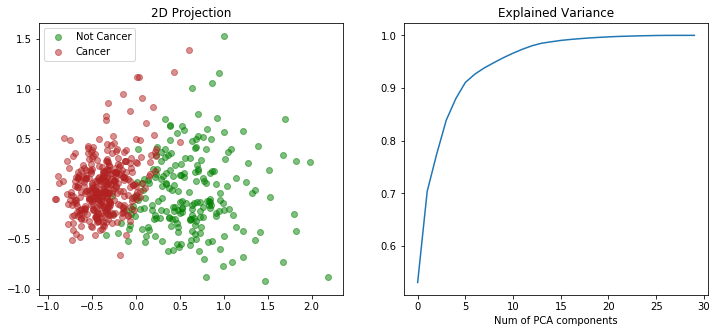

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].scatter(X_pca[y==0][:,0], X_pca[y==0][:, 1], c='green', alpha=0.5, label='Not Cancer')
ax[0].scatter(X_pca[y==1][:,0], X_pca[y==1][:, 1], c='firebrick', alpha=0.5, label='Cancer')
ax[0].legend(loc='upper left')
ax[0].set_title('2D Projection')
ax[1].plot(pca.explained_variance_ratio_.cumsum())
ax[1].set_xlabel('Num of PCA components')
ax[1].set_title('Explained Variance')

---

### Ejercicio: Traduce el siguiente script a un pipeline y evalualo en el dataset de testeo.

Nota: En vez de seleccionar manualmente el umbral de varianza explicada para el PCA, introduce el número de componentes en el gridsearch del pipeline.

In [37]:
import pandas as pd
from sklearn.datasets import load_wine
data = load_wine()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['y'] = data.target

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df.y,
                                                    test_size = 0.33, random_state=123)
###########################################
## Transformation 1: Polynomial Features ##
###########################################

from sklearn.preprocessing import PolynomialFeatures

#instantiate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True)

# fit scaler to train data
poly.fit(X_train)

# scale X_train
X_train_poly= poly.transform(X_train)

#######################################
## Transformation 2: feature scaling ##
#######################################

## It is important to only to fit the transformer on the train dataset!
from sklearn.preprocessing import StandardScaler

# instantiate scaler
scaler = StandardScaler()

# fit scaler to train data
scaler.fit(X_train_poly)

# scale X_train
X_train_poly_scaled= scaler.transform(X_train_poly)

###########################
## Transformation 3: PCA ##
###########################

from sklearn.decomposition import PCA

# instantiate pca
pca = PCA()

# fit PCA to scaled train data
pca.fit(X_train_poly_scaled)

# scale X_train
X_train_poly_scaled_pca = pca.transform(X_train_poly_scaled)

#########################################
## Transformation 4: Feature Selection ##
#########################################

# Num of components needed to reach 95%
num_comp_95 = pca.explained_variance_ratio_[pca.explained_variance_ratio_.cumsum() < 0.95].shape[0]

# instantiate pca with number of components desired
pca = PCA(num_comp_95)

# refit PCA to scaled train data
pca.fit(X_train_poly_scaled)

# scale X_train
X_train_final = pca.transform(X_train_poly_scaled)

##################
## Modelization ##
##################

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Define stratified kfold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

## Instantiate Random Forest
clf_rf = RandomForestClassifier()

## set up a parameter grid for the gridsearch
params_clf_rf = {'max_depth': [2, 3, 4],
                 'min_samples_leaf': [8, 9, 10, 11, 12],
                 'min_samples_split': [3, 4, 5, 6, 7]}

## Instantiate the gridsearch
clf_gs = GridSearchCV(estimator=clf_rf, cv=skfold, param_grid=params_clf_rf, verbose=1, n_jobs=-1)

## Fit the gridsearch
clf_gs.fit(X_train_final, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    4.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4], 'min_samples_leaf': [8, 9, 10, 11, 12], 'min_samples_split': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

### Solution

In [38]:
###########################################
## Transformation 1: Polynomial Features ##
###########################################

from sklearn.preprocessing import PolynomialFeatures

#instantiate polynomial features
step_poly = ('poly', PolynomialFeatures())

#######################################
## Transformation 2: feature scaling ##
#######################################

from sklearn.preprocessing import StandardScaler

step_scaler = ('scaler', StandardScaler())

###########################
## Transformation 3: PCA ##
###########################

from sklearn.decomposition import PCA

step_pca = ('pca', PCA())

##################
## Modelization ##
##################

from sklearn.ensemble import RandomForestClassifier

model_step = ('clf', RandomForestClassifier())

##########################
## Make pipe            ##
##########################
from sklearn.pipeline import Pipeline

pipe_steps = [step_poly, step_scaler, step_pca, model_step]
pipe = Pipeline(pipe_steps)


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

## Define stratified kfold
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

params_pipe = {'poly__degree': [2, 3],
               'pca__n_components': [9, 10, 11],
               'clf__max_depth': [3, 4],
               'clf__min_samples_leaf': [8, 9, 10],
               'clf__min_samples_split': [5, 6, 7]}

## Instantiate the gridsearch
clf_gs = GridSearchCV(pipe, cv=skfold, param_grid=params_pipe, verbose=1, n_jobs=-1)

## Fit the gridsearch
clf_gs.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   15.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1234, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', Ra...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'poly__degree': [2, 3], 'pca__n_components': [9, 10, 11], 'clf__max_depth': [3, 4], 'clf__min_samples_leaf': [8, 9, 10], 'clf__min_samples_split': [5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [39]:
print(clf_gs.best_estimator_.named_steps)

{'poly': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'pca': PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)}


In [40]:
y_test_pred = clf_gs.predict(X_test)

In [41]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.52      0.88      0.65        16
          1       0.89      0.76      0.82        21
          2       1.00      0.64      0.78        22

avg / total       0.83      0.75      0.76        59



## 2. Feature unions

Hasta ahora, solo hemos trabajado con un tipo de variables: númericas. Sin embargo, si tuvieramos variables categóricas, deberíamos tratarlas de forma distinta. Por ejemplo, haciendo un OneHotEncoding.

Las feature unions nos permiten trabajar con transformaciones según el tipo de variable, para despues unirlas antes de pasarlas al modelo de ML.

<img src='img/pipeline+featunion.png'>

In [42]:
import pandas as pd

#data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', header=None)
#data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'y_rings']

data = pd.read_csv('data/abalone.csv',)

In [43]:
data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,y_rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [44]:
data['sex'] = data['sex'].map({'F':0, 'I':1, 'M':2})

In [45]:
from sklearn.base import TransformerMixin

### aux functions

class SelectColumns(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, *y):
        return self
    def transform(self, X):
        return X[[self.columns]].values
    
class DropColumns(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, *y):
        return self
    def transform(self, X):
        return X.drop([self.columns], axis=1).values

** transformation to one-hot-encode 'sex' feature**

In [46]:
from sklearn.preprocessing import OneHotEncoder

select_col_step = ('select', SelectColumns('sex'))
one_hot_step = ('sex_one_hot', OneHotEncoder())
cat_pipe_steps = [select_col_step, one_hot_step]
cat_pipe = Pipeline(cat_pipe_steps)

** transformation of the numeric values by MinMaxScaler **

In [47]:
from sklearn.preprocessing import MinMaxScaler

drop_column_step = ('drop_column', DropColumns('sex'))
poly_step = ('poly', PolynomialFeatures(2,  interaction_only=True))
scaler_step = ('scaler', MinMaxScaler())
num_pipe_steps = [drop_column_step, poly_step, scaler_step]
num_pipe = Pipeline(num_pipe_steps)

** Join the two pipes using feature union **

In [48]:
from sklearn.pipeline import FeatureUnion

transformer_list = [('num_pipe', num_pipe),
                    ('cat_pipe', cat_pipe)]

full_pipe = FeatureUnion(transformer_list=transformer_list)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y_rings', axis=1), data.y_rings, test_size=0.2)

In [50]:
from sklearn.linear_model import LassoCV

In [51]:
reg = LassoCV(cv=5, max_iter=10000, alphas=[0.1, 0.01, 0.001, 0.0001])

In [52]:
X_train_trans = full_pipe.fit_transform(X_train)

In [53]:
reg.fit(X_train_trans.toarray(), y_train)

/home/juanito/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/juanito/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=[0.1, 0.01, 0.001, 0.0001], copy_X=True, cv=5, eps=0.001,
    fit_intercept=True, max_iter=10000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [54]:
y_test_pred_pipe = reg.predict(full_pipe.transform(X_test).toarray())

In [55]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_test_pred_pipe))

1.58234325324


In [56]:
bins = y_test.unique().shape[0]

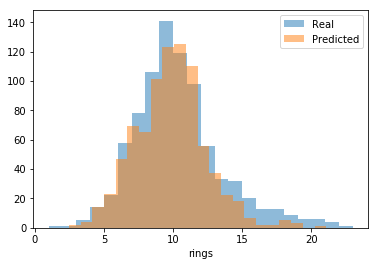

In [57]:
plt.hist(y_test, alpha=0.5, bins=bins, label='Real')
plt.hist(y_test_pred_pipe, alpha=0.5, bins=bins, label='Predicted')
plt.xlabel('rings')
plt.legend(loc='best')
plt.show()

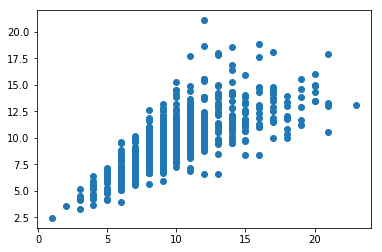

In [58]:
plt.scatter(y_test, y_test_pred_pipe)